#Ejercicios

- Pruebe otras combinaciones de kernels para entrenar el regresor.

- Estudie la influencia del hiperparámetro alpha en los resultados.

- Entrene un regresor por procesos Gaussianos para la señal del punto 2.3 del [P1_CursoDirigido_Seminario_Pos.pdf](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/Parciales/P1_CursoDirigido_Seminario_Pos.pdf).



Sea la señal:

$$
t_n = A \sin(2\pi F_1 x_n) + B \cos(2\pi F_2 x_n) + \eta_n, \quad A, B \in \mathbb{R}
$$

contaminada con ruido blanco Gaussiano con $$ \text{SNR}_{\text{db}} = 2 \text{[dB]} $$. Asuma un mapeo $$ \phi(\cdot) $$ del tipo RBF, definido como:

$$
\phi(x_n) = [\mathcal{N}(x_n|\mu_q, \sigma_q^2)]_{q=1}^{Q}
$$

donde $$ Q = 20 $$, y

$$
p(w) = \mathcal{N}(w|m_0, S_0)
$$

Se deben simular 100 datos para entrenar los modelos y 20 para predecir, incluyendo un ciclo de la señal estudiada en la simulación.


In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict,ShuffleSplit

#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel
import matplotlib


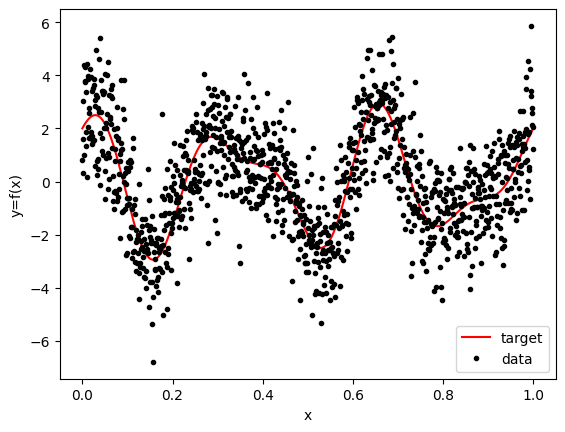

In [50]:
def var_snr(x,snrdB): #Función que entrega la varianza del ruido tomando en cuenta su potencia en dB
    Px = np.mean(x**2)
    return Px/(10**(snrdB/10))

A = 1
B = 2
f1 = 5
f2 = 3
N = 1200 #número de muestras

X = np.linspace(0, 1, N) #vector de entrada
y = A*np.sin(2*np.pi*f1*X) + B*np.cos(2*np.pi*f2*X)  #función -> objetivo

snrdB = 2
var = var_snr(y,snrdB)
noise = np.random.normal(0,np.sqrt(var), N)

yn = y + noise #señal co ruido

plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [51]:
ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) 
print(ydata.shape) 

(1200, 1)
(1200, 1)


0
(1000, 1)
(200, 1)


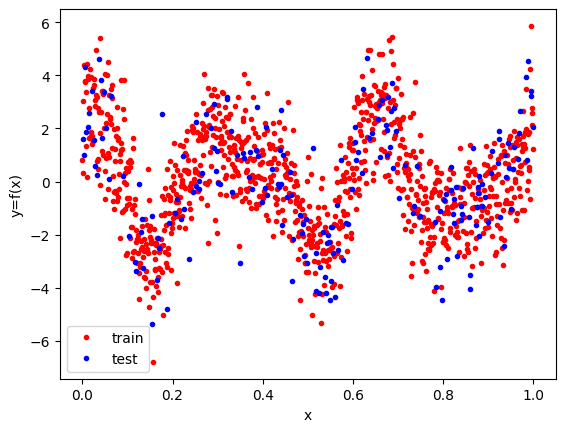

In [52]:
#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=200/N)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


X_train, X_test, y_train, y_test = Xdata[train_i], Xdata[test_i], ydata[train_i], ydata[test_i]

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [53]:

ind_ = np.argsort(X_test,axis=0).reshape(-1)

X, x = X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel()

#definir gpr
alpha = 0.1 #*1/np.var(y_train)#1e-5

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=1, length_scale_bounds=(1e-1, 10.0)) \
         + ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0)) \
         + ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * ExpSineSquared(length_scale=1.0, periodicity=1.0, 
          length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))


gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

n_samples = 5

# plot posterior
gpr_model.fit(X_train, y_train) #entrenar GPR en train

y_mean, y_std = gpr_model.predict(X, return_std=True) #predicted output from gpr
y_samples = gpr_model.sample_y(X, n_samples)

c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: Conv

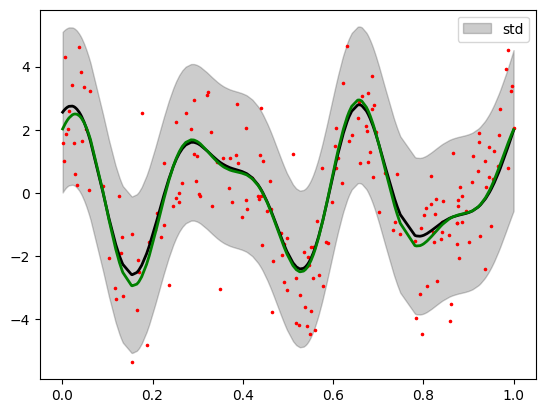

In [54]:
plt.plot(x, y_mean, color="black", lw=2)
plt.fill_between(
        x,
        y_mean - 2*y_std,
        y_mean + 2*y_std,
        alpha=0.2,
        color="black",
        label="std"
    )
plt.scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
plt.plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
plt.legend()
plt.show()